<a href="https://colab.research.google.com/github/catalinabustam/tms_hmm/blob/master/hmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HHM in TMS with resting state fmri

### Install and import libraries

In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 368kB 5.4MB/s 


In [ ]:
from hmmlearn import hmm
import pandas as pd
import numpy as np
import glob
import os
import h5py
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### Load google drive

### Define data location

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dirpath = '/content/drive/My Drive/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
parcel_path = '_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz'

### Function to load data

In [ ]:
def get_time_series(dirpath, subects, stimulus, scan, parcel, scaler ):
    
    subject_list = []
    
    for subject in subjects:
        file_path = f'{dirpath}{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/clean_roi_csv/roi_stats.csv'
        series = np.genfromtxt(file_path,delimiter='\t',skip_header=1)
        series_s = scaler.fit_transform(series)
        subject_list.append(series_s)
    
    return np.array(subject_list)


### Function to create left to right transmat


In [ ]:
def create_lf_matrix(states,delta=None):
  transmat = np.triu(np.ones((states,states)))
  nonzero = np.nonzero(transmat)
  
  if delta:
    for i in range(len(nonzero[0])):
      m = nonzero[0][i]
      n = nonzero[1][i]
    
      if (n > (m+ delta)):
        transmat[m,n] = 0
  
  transmat = (transmat.T/np.count_nonzero(transmat, axis=1))
  
  return transmat.T

### Load and concatenate time series

In [ ]:
def get_all_data(scans, stimuli,scaler ):
  all_c = np.empty((0, 600, 400))
  for scan in scans:
    for stimulus in stimuli:
      stimu_array = get_time_series(dirpath, subjects, stimulus, scan, parcel_path, scaler)
      all_c = np.append(all_c, stimu_array, axis=0)
  return all_c

### Define variables

In [ ]:
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]
scaler = StandardScaler()
states = 17

In [ ]:
all_c = get_all_data(scans, stimuli,scaler )
all_data = np.reshape(all_c, (all_c.shape[1]*all_c.shape[0], all_c.shape[2]))
lenghts = [all_c.shape[1] for i in range(all_c.shape[0])]

### Define and train  hmm model

In [ ]:
hmm_lr = hmm.GaussianHMM(n_components=states, covariance_type="full")
startprob = np.zeros(states)
startprob[0] = 1
#hmm_lr.startprob_ = startprob
#hmm_lr.transmat_ = create_lf_matrix(states,2)


In [ ]:
hmm_lr.fit(all_data, lenghts)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=17, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [ ]:
predicted_sequences =  [hmm_lr.predict(array) for array in all_c.tolist()]


In [ ]:
def plot_states(predicted_sequences):
  f, ax = plt.subplots(1,1, figsize=(30, 10))

  fig = ax.imshow(predicted_sequences, cmap='tab20', aspect='auto')
  f.colorbar(fig, orientation='vertical')
  ax.hlines(y=23, xmin=0, xmax=590, linewidth=2, color='w')
  ax.hlines(y=46, xmin=0, xmax=590, linewidth=2, color='w')
  ax.hlines(y=69, xmin=0, xmax=590, linewidth=2, color='w')

  ax.hlines(y=92, xmin=0, xmax=590, linewidth=2, color='w')
  ax.hlines(y=115, xmin=0, xmax=590, linewidth=2, color='w')

  ax.set_title('Estimated brain pattern for each event')
  ax.set_ylabel('Event id')
  ax.set_xlabel('ROIS')

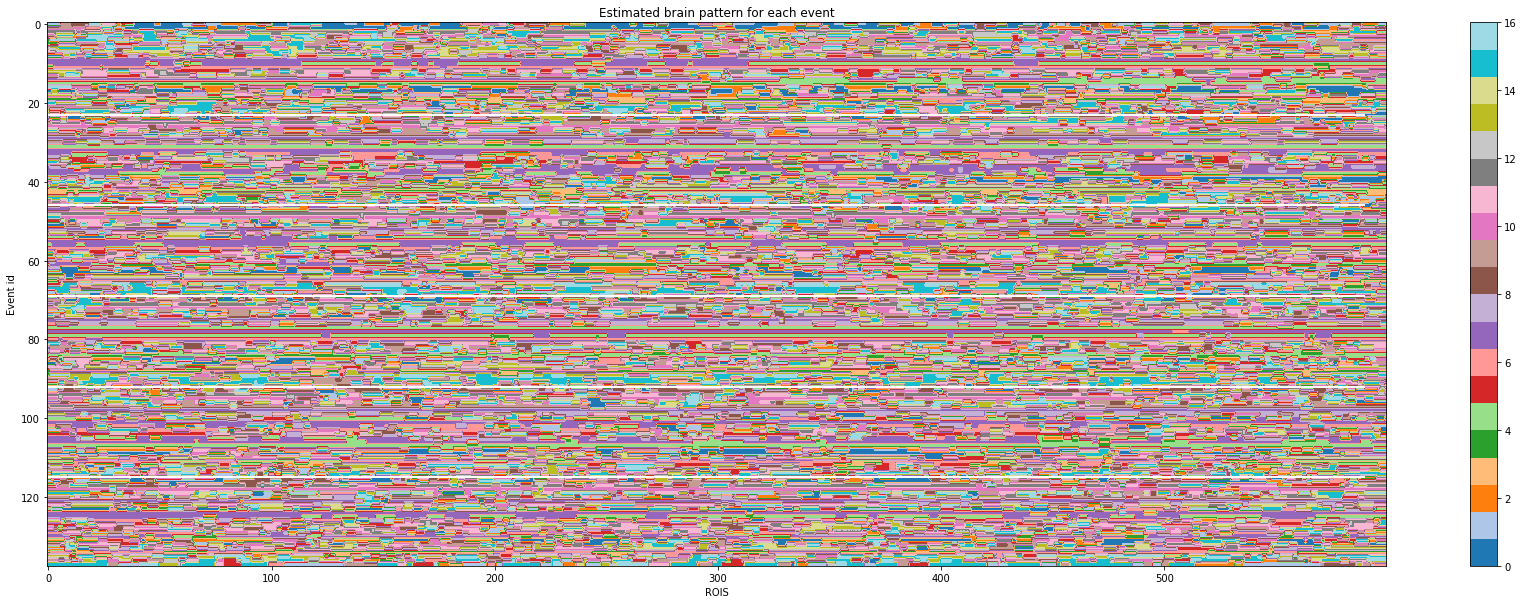

In [ ]:
plot_states(predicted_sequences)

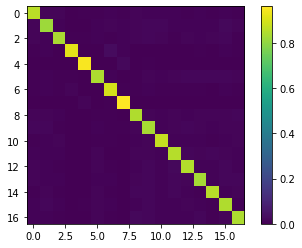

In [ ]:
hmm_lr.transmat_
plt.imshow(hmm_lr.transmat_)
plt.colorbar()
plt.show()

In [ ]:
hmm_lr.transmat_

NameError: ignored

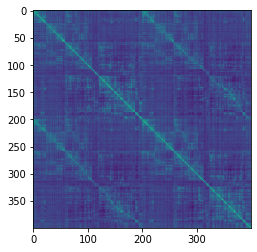

In [ ]:
plt.imshow(hmm_lr.covars_[1])

##Using MIN MAX Scaler

In [ ]:
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]
scaler = MinMaxScaler()
states = 17

In [ ]:
all_c = get_all_data(scans, stimuli,scaler )
all_data = np.reshape(all_c, (all_c.shape[1]*all_c.shape[0], all_c.shape[2]))
lenghts = [all_c.shape[1] for i in range(all_c.shape[0])]

In [ ]:
hmm_lr = hmm.GaussianHMM(n_components=states, covariance_type="diag", init_params="cm", params="cmt")
startprob = np.zeros(states)
startprob[0] = 1
hmm_lr.startprob_ = startprob
hmm_lr.transmat_ = create_lf_matrix(states)

In [ ]:
hmm_lr.fit(all_data, lenghts)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='cm', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=17, n_iter=10, params='cmt',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

Text(0.5, 0, 'ROIS')

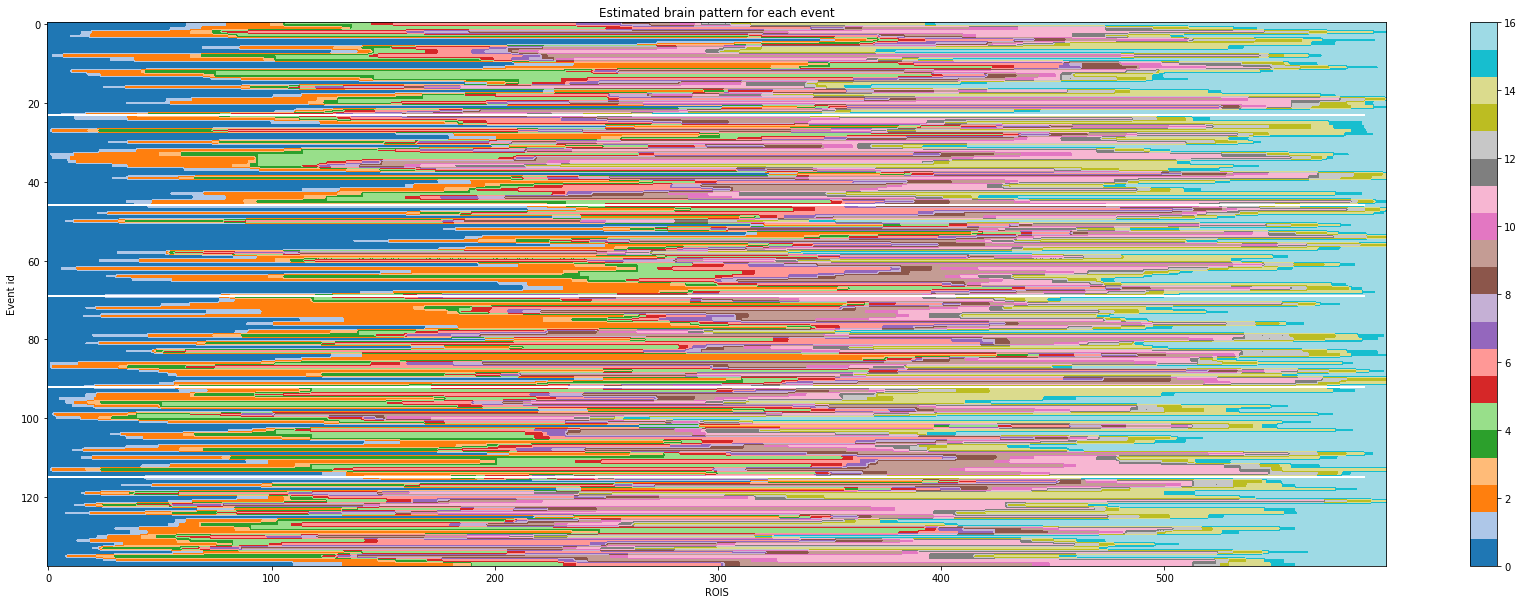

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30, 10))

fig = ax.imshow(predicted_sequences, cmap='tab20', aspect='auto')
f.colorbar(fig, orientation='vertical')
ax.hlines(y=23, xmin=0, xmax=590, linewidth=2, color='w')
ax.hlines(y=46, xmin=0, xmax=590, linewidth=2, color='w')
ax.hlines(y=69, xmin=0, xmax=590, linewidth=2, color='w')

ax.hlines(y=92, xmin=0, xmax=590, linewidth=2, color='w')
ax.hlines(y=115, xmin=0, xmax=590, linewidth=2, color='w')

ax.set_title('Estimated brain pattern for each event')
ax.set_ylabel('Event id')
ax.set_xlabel('ROIS')

#Left to Right without restriction 

In [ ]:
 def create_lf_matrix_w(states):
  transmat = np.zeros((states,states))

  for i in range(states):
    transmat[i,i:states] = 1/(states-i)
  return transmat

In [ ]:
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]
scaler = StandardScaler()
states = 17

In [ ]:
all_c = get_all_data(scans, stimuli,scaler )
all_data = np.reshape(all_c, (all_c.shape[1]*all_c.shape[0], all_c.shape[2]))
lenghts = [all_c.shape[1] for i in range(all_c.shape[0])]

NameError: ignored

In [ ]:
hmm_lr = hmm.GaussianHMM(n_components=states, covariance_type="diag", init_params="cm", params="cmt")
startprob = np.ones(states)*(1/states)
hmm_lr.startprob_ = startprob
hmm_lr.transmat_ = create_lf_matrix_w(states)

In [ ]:
hmm_lr.fit(all_data, lenghts)

In [ ]:
predicted_sequences =  [hmm_lr.predict(array) for array in all_c.tolist()]

In [ ]:
plot_states(predicted_sequences)